# Imports

In [1]:
import sys  
sys.path.insert(1, '..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from torch.utils.data import TensorDataset
import os 
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import pandas as pd
from nilearn import masking
import torch.nn.functional as F
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.model_selection import KFold
from src.utils_train import train_one, val_step_one, train, val_step

# REPRODUCIBILITY

In [3]:
device ="cuda" if torch.cuda.is_available() else "cpu"
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# SETUP

In [4]:
TRAIN = True
ONE_NODE_OUT = False

act_func = F.sigmoid if ONE_NODE_OUT else lambda y: F.softmax(y, dim=1) 
dir = "2D_results/"
if not os.path.isdir(dir): os.mkdir(dir)

# Loading brain Mask
Extracting the number of pixel in the brain slice

In [5]:
brain_mask = np.load("../src/sim_brain.npy")
img_shape = brain_mask.shape
total_brain_voxel = int(np.sum(brain_mask))
total_brain_voxel

5290

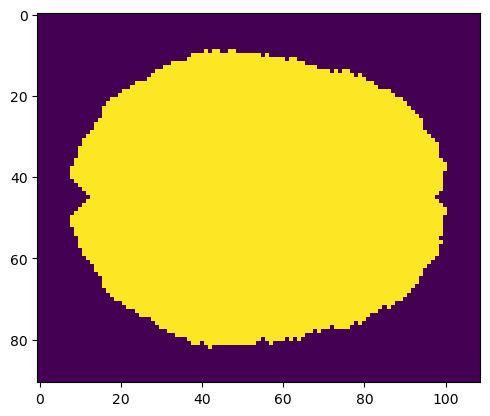

In [6]:
plt.imshow(brain_mask)

# DATASET CREATION

In [7]:
n_samples = 2500
n_features = total_brain_voxel
n_classes = 2
n_informative = int(total_brain_voxel/100)
X, y = make_classification(n_samples, n_features= n_features, n_classes=n_classes, random_state=seed,n_informative=n_informative, shift=5,n_redundant=0, n_clusters_per_class=1, class_sep = 2.5, shuffle=False)
X.shape

(2500, 5290)

In [8]:
tot_idx = range(n_samples)
train_idx, test_idx = train_test_split(tot_idx, test_size = 0.15, random_state=seed)
y_train = y[train_idx]
y_test =y[test_idx]


## Feature pre-processing
Given the $N$ features we shuffle them and apply a gaussian filter to "spalmare" the values

In [9]:
indexes = np.arange(total_brain_voxel)
np.random.shuffle(indexes)

Showing the shuffle worked

In [10]:
a = X[0][indexes]
a[np.where(indexes == 0)], X[0][0]

(array([12.09202478]), 12.092024775878418)

In [11]:
shuffle_X = np.zeros(X.shape)
for i in range(n_samples):
    shuffle_X[i] = X[i][indexes]

processed_data = np.empty((n_samples, *img_shape))
brain_mask_position = np.where(brain_mask==1)
processed_data.shape

(2500, 91, 109)

Feature into brain mask

In [12]:
for i in range(n_samples):
    processed_data[i][brain_mask_position] = shuffle_X[i]


Text(0.5, 1.0, 'Class 1 sample')

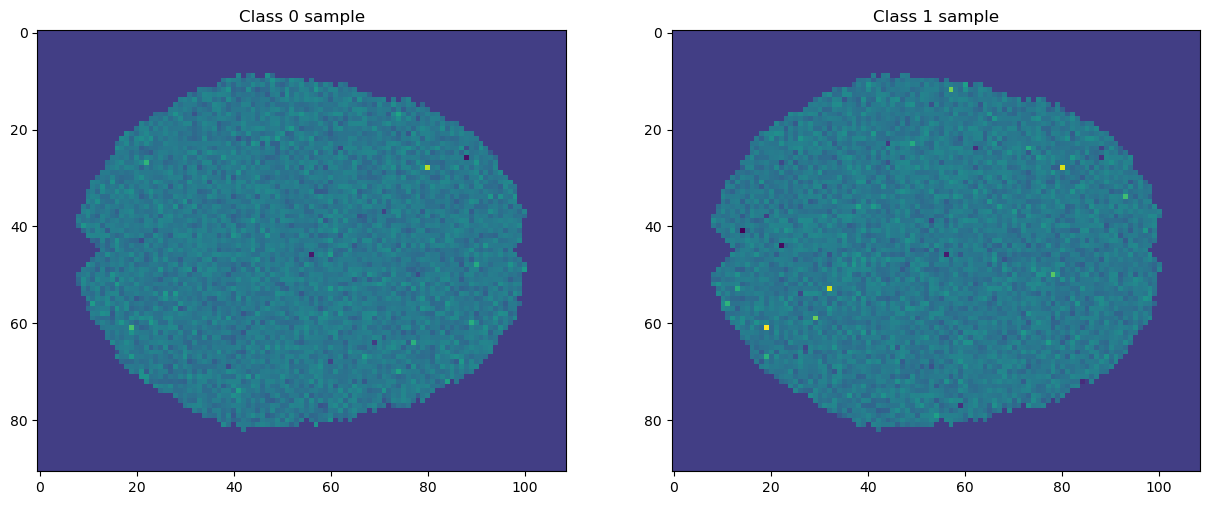

In [13]:
max = np.max([np.max(processed_data[np.where(y == 0)[0][0]]),np.max(processed_data[np.where(y == 1)[0][0]])])
min = np.min([np.min(processed_data[np.where(y == 0)[0][0]]),np.min(processed_data[np.where(y == 1)[0][0]])])
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
ax0.imshow(processed_data[np.where(y == 0)[0][0]], vmin=min, vmax = max)
ax1.imshow(processed_data[np.where(y == 1)[0][0]],vmin=min, vmax = max)
ax0.set_title("Class 0 sample")
ax1.set_title("Class 1 sample")

Extracting `n_informative` features indexes in the brain img 

In [14]:
list_id = []
for id in range(n_informative):
    list_id.append(np.where(indexes == id)[0][0])

list_id = np.array(list_id)

In [15]:
temp = np.zeros(img_shape)
temp2 = np.zeros(total_brain_voxel)
temp2[:] = np.nan
temp2[list_id] = 150
temp[brain_mask_position] = temp2

Showing the `n_informative` features

Text(0.5, 1.0, 'Informative fetures location')

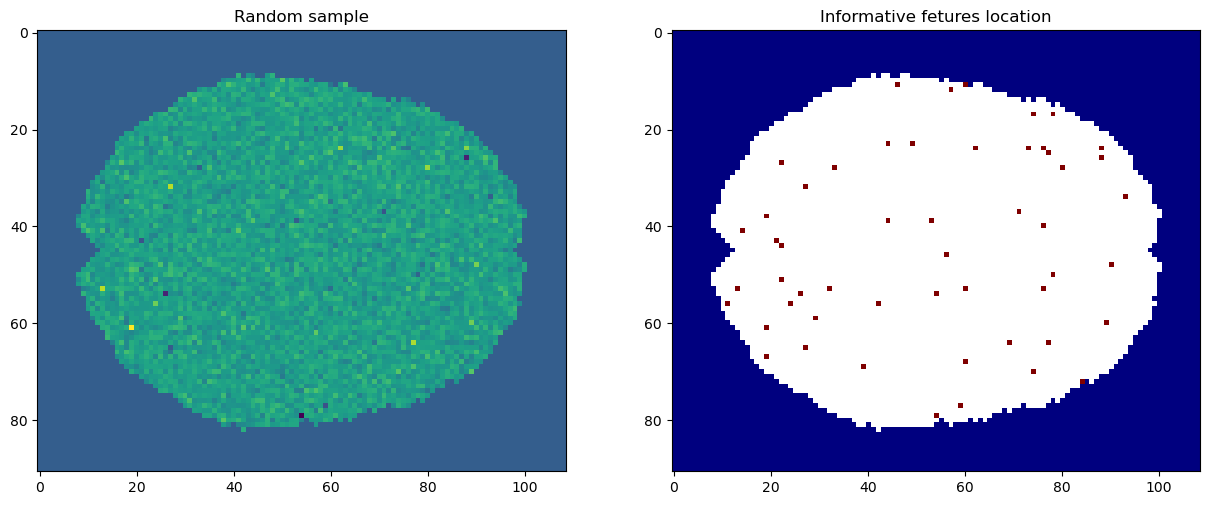

In [16]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
ax0.imshow(processed_data[1],)
ax1.imshow(temp, cmap="jet")
ax0.grid(False); ax1.grid(False)
ax0.set_title("Random sample"); ax1.set_title("Informative fetures location")

In [17]:
ind = []
for i,a in zip(*np.where(temp == 150)):
    ind.append([i,a])

Preprocessing

In [18]:
for i in range(n_samples):
    #blurred_shuffle = ndimage.gaussian_filter(processed_data[i][brain_mask_position], sigma=2)
    processed_data[i]= ndimage.gaussian_filter(processed_data[i], sigma=2)

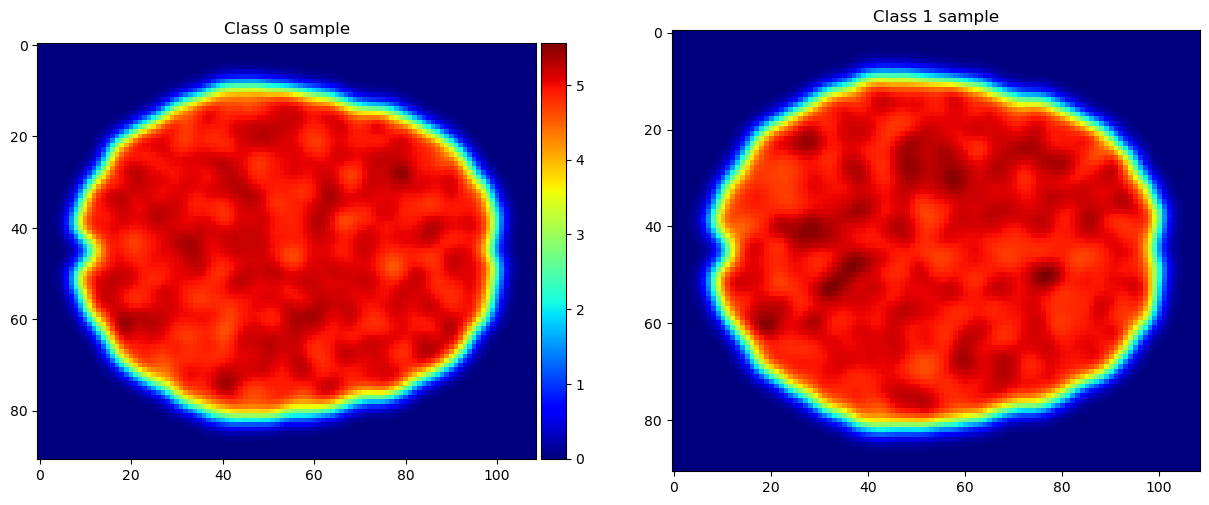

In [19]:
max = np.max([np.max(processed_data[np.where(y == 0)[0][0]]),np.max(processed_data[np.where(y == 1)[0][0]])])
min = np.min([np.min(processed_data[np.where(y == 0)[0][0]]),np.min(processed_data[np.where(y == 1)[0][0]])])
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
img = ax0.imshow(processed_data[np.where(y == 0)[0][0]], vmin=min, vmax = max, cmap="jet")
ax1.imshow(processed_data[np.where(y == 1)[0][0]],vmin=min, vmax = max, cmap="jet")
ax0.set_title("Class 0 sample")
ax1.set_title("Class 1 sample")
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax0, orientation='vertical')

# NEURAL NETWORK

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool1 = nn.MaxPool2d(2)
        

        self.conv3 = nn.Conv2d(16,32, 3)
        self.conv4 = nn.Conv2d(32,32, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 18 * 23, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1 if ONE_NODE_OUT else n_classes )
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.dp = nn.Dropout(0.4)

        

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(self.relu2(self.conv2(x)))
        x = self.relu1(self.conv3(x))
        x = self.pool2(self.relu2(self.conv4(x)))

        x = x.view(-1, 32 * 18 * 23)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.dp(x)
        x = self.fc3(x)
        return x


net = Net()

# TRAINING

## CROSS VALIDATION

In [21]:
#generatin the 10 fold data
folds = 10
NUM_EPOCHS = 15
if TRAIN:
  

	kf = KFold(n_splits=folds)#,random_state=42, shuffle=True

	# Continue the training and validation of the model for all the other folds
	for i, (train_index, test_index) in (enumerate(kf.split(train_idx))):
		net = Net()
		loss_fn = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()
		optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-6)
		# Keeping the split
		train_str = "train_"+str(i)
		val_str = "val_"+str(i)

		ds_train = TensorDataset(torch.tensor(processed_data[train_idx][train_index], device="cuda", dtype=torch.float32).view(-1,1,*img_shape), torch.tensor(y_train[train_index], device="cuda", dtype=torch.float32 if ONE_NODE_OUT else torch.long).view(-1,1))#, transform=transforms.ToTensor()
		ds_test = TensorDataset(torch.tensor(processed_data[train_idx][test_index], device="cuda", dtype=torch.float32).view(-1,1,*img_shape), torch.tensor(y_train[test_index],device="cuda", dtype=torch.float32 if ONE_NODE_OUT else torch.long).view(-1,1))
		trainloader = DataLoader(ds_train,batch_size=16,shuffle=True)
		validationloader = DataLoader(ds_test,batch_size=16)
		net.to("cuda")
		from timeit import default_timer as timer
		start_time = timer()
		# Train model
		tr = train_one if ONE_NODE_OUT else train
		model_results = tr(model=net,
								train_dataloader=trainloader,
								val_dataloader=validationloader,
								optimizer=optimizer,
								loss_fn=loss_fn,
								epochs=NUM_EPOCHS,
								split=i,
								dir=dir)
		# End the timer and print out how long it took
		end_time = timer()
		print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")

		# Extract train and validation loss and accuracy at each epoch
		results = dict(list(model_results.items()))

		# Get the loss values of the results dictionary (training and validation)
		train_loss = results["train_loss"]
		val_loss = results["val_loss"]

		# Get the accuracy values of the results dictionary (training and validation)
		train_acc = results["train_acc"]
		val_acc = results["val_acc"]

		# Figure out how many epochs there were
		epochs = range(len(results["train_loss"]))

		# Save results in a csv
		results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
		results_df["train_loss"] = train_loss
		results_df["val_loss"] = val_loss
		results_df["train_acc"] = train_acc
		results_df["val_acc"] = val_acc
		results_df["epochs"] = epochs
		results_df_name = f"{dir}/results_df_"+str(i)+".csv"
		results_df.to_csv(results_df_name)

  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 0: 3.433 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 1: 3.090 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 2: 3.245 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 3: 3.445 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 4: 2.743 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 5: 2.935 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 6: 3.483 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 7: 2.776 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 8: 3.321 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Total training time for split 9: 3.226 seconds


Showing `folds` model accuracy on the validation fold, with accuracy and validation curves

In [22]:
sns.set_theme()
results = []
val_accuracies = np.zeros([10,1])
for i in range(folds):
	results.append(pd.read_csv(f"{dir}/results_df_{i}.csv"))
	val_accuracies[i] = np.max(results[i]["val_acc"])

# Get the fold corresponding to the overall best
index = np.argmax(val_accuracies)


res = pd.concat(results)
res = res.map(lambda x: np.nan if x in [np.inf, -np.inf] else x)
len(results), index, val_accuracies

(10,
 0,
 array([[8.35535714],
        [8.19464286],
        [8.17857143],
        [8.17678571],
        [8.07142857],
        [8.05357143],
        [8.1875    ],
        [8.        ],
        [8.17857143],
        [8.13392857]]))

<Axes: xlabel='epochs', ylabel='train_acc'>

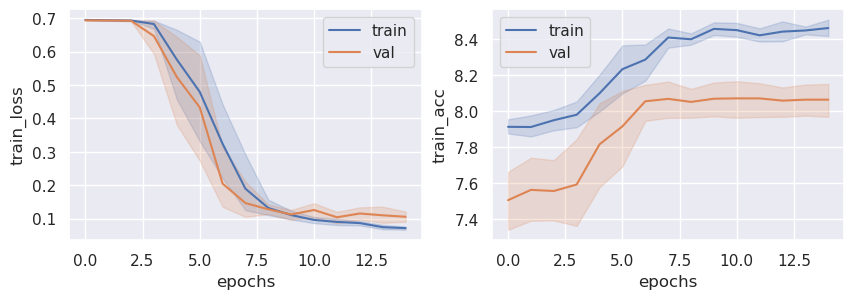

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.lineplot(data=res, x="epochs", y="train_loss", err_style="band", label="train", ax=axs[0])
sns.lineplot(data=res, x="epochs", y="val_loss", err_style="band", label="val", ax=axs[0])
sns.lineplot(data=res, x="epochs", y="train_acc", err_style="band", label="train", ax=axs[1])
sns.lineplot(data=res, x="epochs", y="val_acc", err_style="band", label="val", ax=axs[1])


In [24]:
# Looking across all the best validation accuracies obtained from the ten folds
val_accuracies = np.zeros([10,1])
for i in range(folds):
    results_string = f"{dir}/results_df_"+str(i)+".csv"
    val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])

# Get the fold corresponding to the overall best
index = np.argmax(val_accuracies)
index

0

In [25]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=device)
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [26]:
# Holdout setup
x_holdout_tensor =  torch.tensor(processed_data[test_idx], dtype=torch.float32).to(device)
y_binary_test_tensor = torch.tensor(y_test, dtype=torch.float32 if ONE_NODE_OUT else torch.long).to(device).view(-1,1)
ds_holdout=TensorDataset(x_holdout_tensor.view((-1,1,*img_shape)),y_binary_test_tensor)
holdout_loader = DataLoader(ds_holdout,batch_size=16)


In [27]:
val_accuracies = np.zeros([10,1])
for i in range(folds):
    model_string = f"{dir}/checkpoint_"+str(i)+".pth"
    model_cp = load_checkpoint(model_string)
    # model_cp.to(device)
    vs = val_step_one if ONE_NODE_OUT else val_step
    val_loss, val_accuracies[i], f1,_= vs(model=model_cp,
                dataloader=holdout_loader,
                loss_fn=loss_fn)
    print("ACCURACY: ", val_accuracies[i], "F1: ",f1)
index = np.argmax(val_accuracies)
index

ACCURACY:  [8.06547619] F1:  0.9562982005141388
ACCURACY:  [8.08110119] F1:  0.9627659574468085
ACCURACY:  [8.03943452] F1:  0.9509043927648578
ACCURACY:  [8.08110119] F1:  0.96875
ACCURACY:  [7.625] F1:  0.0
ACCURACY:  [8.09151786] F1:  0.9655172413793104
ACCURACY:  [8.09151786] F1:  0.9620253164556962
ACCURACY:  [7.625] F1:  0.0
ACCURACY:  [8.01860119] F1:  0.924791086350975
ACCURACY:  [8.05505952] F1:  0.9536082474226805


/tmp/ipykernel_1137007/1196447774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath,map_location=device)
/tmp/ipykernel_1137007/1196447774

5

## Loading best model

In [28]:
basic_acc = np.nan
model_string = f"{dir}/checkpoint_"+str(index)+".pth"
model_cp = load_checkpoint(model_string)
loss_fn = nn.CrossEntropyLoss().to(device) 
print(model_cp)

val_loss, val_acc, f1,_ = vs(model=model_cp,
            dataloader=holdout_loader,
            loss_fn=loss_fn)
print("\nACCURACY: ", val_acc, "\nF1: ",f1)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13248, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (dp): Dropout(p=0.4, inplace=False)
)

ACCURACY:  8.091517857142858 
F1:  0.9655172413793104


/tmp/ipykernel_1137007/1196447774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath,map_location=device)


Splitting data by model classification

In [29]:
classifed_idx = [[],[]]
for img, lab, index in zip(processed_data[train_idx], y[train_idx], train_idx):
    softmax_pred = act_func(model_cp(torch.tensor(img, dtype=torch.float32).view(1,1, *img.shape).to(device)))
    pred_idx = softmax_pred.round().squeeze() if ONE_NODE_OUT else torch.argmax(softmax_pred, dim=1)
    if pred_idx.item() == lab:
        classifed_idx[int(pred_idx)].append(index)

# IBS

In [30]:
pred_bound = 1/n_classes
def IBS(bs, model, target_class_0,target_class_1, precision = 0.05, iter = False, ret_fail = False, device = 'cpu', noise_mul = 2, path:bool = True):
    '''
    Informed Baseline Search with a starting point, and a pool of targets computes a sample of the inner boundary (baseline) of a NN
        
    :param bs: starting point
    :param model: model to be investigated
    :param target_class_0/target_class_1: data of the target pool for class 0 and class 1, can be a single sample for each class
    :param precision: precision of the baseline (.5-precision < predict(bs) < .5+precision needs to be met to consider baseline)
    :param iter: True if target_class_0 and target_class_0 are iterators, otherwise false
    :param ret_fail: True to return 1 if the IBS failed to find a DB sample
    :param device: device
    :param noise_mul: scalar factor to modify the step intensity
    :param path: True to return all pointed computed in the search
    
    :returns bs: baseline computed
    :returns temp_bs: path computed if path is false returns the starting point
    :returns fail: (optional) 1 if IBS fails otherwhise 0
    
    '''
    
    model = model.to(device)
    if not isinstance(bs, torch.Tensor): bs = torch.tensor(bs, dtype=torch.float32)
    bs = bs.to(device)
    acc=[]
    temp_bs = [bs.cpu().numpy()]
    
    out = model(bs)
    pred = act_func(out)[0].cpu().detach().numpy()
    while(True):
        acc.append( pred )
        if ((pred_bound-precision) < pred ).all() and (pred <(pred_bound+precision)).all():
            if path: temp_bs.append(bs.cpu().numpy())
            return (bs, temp_bs,0) if ret_fail else (bs, temp_bs)
            
        softmax_pred = act_func(out)
        pred_idx = softmax_pred.round() if ONE_NODE_OUT else torch.argmax(softmax_pred, dim=1)
        pred_value = softmax_pred if ONE_NODE_OUT else softmax_pred[0,pred_idx]
        
        try:
            if iter:
                i1_idx = next(target_class_0) if pred_idx else next(target_class_1)
                i1 = [i1_idx]
            else: 
                i1 = target_class_0 if pred_idx else target_class_1
        except StopIteration: print("out of data"); break

        
        
        i1 = torch.tensor(np.array(i1), dtype=torch.float32).to(device)
        direction = (i1-bs)
        multi = ((2000/2-len(acc)) / 2000/2)*noise_mul

        intensity = round(((pred_value-(1-pred_value))/2).item()*multi,5)
        intensity = abs(intensity)
        weighted_input = direction*intensity
        bs = bs + weighted_input
        if path:temp_bs.append(bs.cpu().numpy())
        out = model(bs)
        pred = act_func(out)[0].cpu().detach().numpy()

    return (bs,temp_bs,1) if ret_fail else (bs,temp_bs)

# Integrated Gradients

In [31]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=False, softmax = False):
    """
   	Computes the model gradients with respect to input, inputs (batch x 1 x *img_shape) 
   	"""
    gradients = []
    for input in inputs:
        if not isinstance(input, torch.Tensor):
          input = torch.tensor(input.detach().clone(), dtype=torch.float32, requires_grad=True)
        else:
           input.requires_grad=True
        output = model(input)
        if softmax:
          output = F.softmax(output, dim=-1)

        output = output[:,target_label_idx]
        grads = torch.autograd.grad(torch.unbind(output), input)[0]
        
        gradients.append(grads.cpu().detach())
    gradients=np.array(gradients)
    return gradients, target_label_idx

In [32]:
def my_IG_attribute(inputs, baselines, net, target=None,steps=50, softmax = False, ret_scaled_inputs=False):
        if target is None:
          _, target = torch.max(net(inputs), 1)

        scaled_inputs = torch.cat([baselines + i * (inputs - baselines) for i in torch.linspace(0,1,steps)],dim=0)

        scaled_inputs = scaled_inputs.view(steps,1,*img_shape)

        grads, _ = calculate_outputs_and_gradients(scaled_inputs, net, target, False, softmax = softmax)
        #Captum approx
        deltas = [1 / steps] * steps
        deltas[0] /= 2
        deltas[-1] /= 2
        
        deltas = np.array(deltas)#.view(steps,-1)
        grads1 = grads.reshape(steps,-1) *deltas.reshape(steps,-1)
        grads1 = grads1.reshape(steps, *img_shape)
        avg_grads = np.average(grads1[:], axis=0)
        var_grads = np.var(grads1[:,], axis=0)
        avg_grads = torch.tensor(avg_grads)
        delta_x = (inputs.cpu().detach().numpy() - baselines.cpu().detach().numpy())[0]
        integrated_grad = delta_x * avg_grads.detach().numpy()
      
        if ret_scaled_inputs: return integrated_grad, avg_grads, var_grads, grads1, scaled_inputs
        return integrated_grad, avg_grads, var_grads, grads1, delta_x


In [33]:
class_0_test_idx = np.where(y_test == 0)[0]
class_1_test_idx = np.where(y_test == 1)[0]

In [34]:
def infer_transf(x):
    return torch.tensor(x, device=device, dtype=torch.float32).view(1,1,*img_shape)

## EMPIRICAL BS

In [35]:
emp_bs= torch.rand(1,*img_shape) 
emp_bs = torch.tensor(emp_bs, dtype=torch.float32).view(1,1,*img_shape).to(device)
print(act_func(model_cp(emp_bs))[0])

tensor([0.4661, 0.5339], device='cuda:0')


/tmp/ipykernel_1137007/227402799.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emp_bs = torch.tensor(emp_bs, dtype=torch.float32).view(1,1,*img_shape).to(device)


In [36]:
def compute_tot_attributions(data, class_1_test_idx, bs, steps = 50, target = 1, class_idx = 0):
    attr_mean = torch.empty(size=(0,*img_shape))
    grad_mean = torch.empty(size=(0,*img_shape))
    delta_mean = torch.empty(size=(0,*img_shape))
    ad_mean = torch.empty(size=(0,*img_shape)).to(device)
    for i in class_1_test_idx:
        input = torch.tensor(data[i], dtype=torch.float32).view(1,1,*img_shape).to(device)
        # input = input.view((1,1, 91,109,91))
        if ONE_NODE_OUT:
            idx_pred= F.sigmoid(model_cp(input)).round()
        else:
            _, idx_pred = F.softmax(model_cp(input), dim=1).max(1)
        if idx_pred.item() == class_idx:
            attr, _,_,grad,delta=my_IG_attribute(input, bs, model_cp, target=target, steps=steps)
            delta_mean= torch.cat((delta_mean, torch.tensor(delta)), axis=0)
            grad_mean = torch.cat((grad_mean, torch.tensor(grad)), axis=0)
            attr_mean = torch.cat((attr_mean, torch.tensor(attr)), axis=0)
            ad_mean = torch.cat((ad_mean, input.view(1,*img_shape)), axis=0)
    AD_attr_tot = torch.mean(attr_mean, dim=0)
    ad_mean_tot = torch.mean(ad_mean, dim=0)
    grad_mean_tot = torch.mean(grad_mean, dim=0)
    delta_mean_tot = torch.mean(delta_mean, dim=0)
    return AD_attr_tot, ad_mean_tot, grad_mean_tot, delta_mean_tot
    # print(f"Prediction class 1 accuracy: {(attr_mean.shape[0]/ class_1_test_idx.shape[0]):.2f}")
        
    
        

In [37]:
class_0_data = processed_data[classifed_idx[0]]
class_1_data = processed_data[classifed_idx[1]]

Running IBS on an inner sample like the mean

In [38]:
mean0 = np.mean(class_0_data, axis = 0)
mean1 = np.mean(class_1_data, axis = 0)
x = (mean0+mean1)/2
bs = IBS(infer_transf(x), model_cp, iter(class_0_data),iter(class_1_data) , precision=0.01,\
                                iter = True, ret_fail=True,device = device, noise_mul = 1/30, path = False)[0]

In [39]:
count = 0
miss = np.zeros(np.prod(bs.shape))
for i,(a,b,c,d) in enumerate(zip(mean0.flatten(),mean1.flatten(),bs.cpu().numpy().flatten(), brain_mask.flatten())):
    if not ((a <= c <=b) or (b <= c <= a)):
        if d > 0.1:
            # print(i, a, c, b, d)
            count +=d
            
        miss[i] = 1
print(count)

144.0


## AVG CLASS TEST

In [40]:
AD_att_bs, ad_mean_bs, grad_bs, delta_bs = compute_tot_attributions(processed_data[test_idx], class_1_test_idx, infer_transf(emp_bs), target=0 if ONE_NODE_OUT else 1, steps=100, class_idx=1)
AD_att, ad_mean, grads, delta = compute_tot_attributions(processed_data[test_idx], class_1_test_idx, infer_transf(bs), target=0 if ONE_NODE_OUT else 1, steps=100, class_idx=1)

/tmp/ipykernel_1137007/2757908933.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, device=device, dtype=torch.float32).view(1,1,*img_shape)


In [41]:
# Thresholding data to visualization (optional)
# AD_att_bs[np.where(np.isclose(AD_att_bs,AD_att_bs.mean(), atol=0.0001))] = np.nan
# AD_att[np.where(np.isclose(AD_att,AD_att.mean(), atol=0.00001))] = np.nan

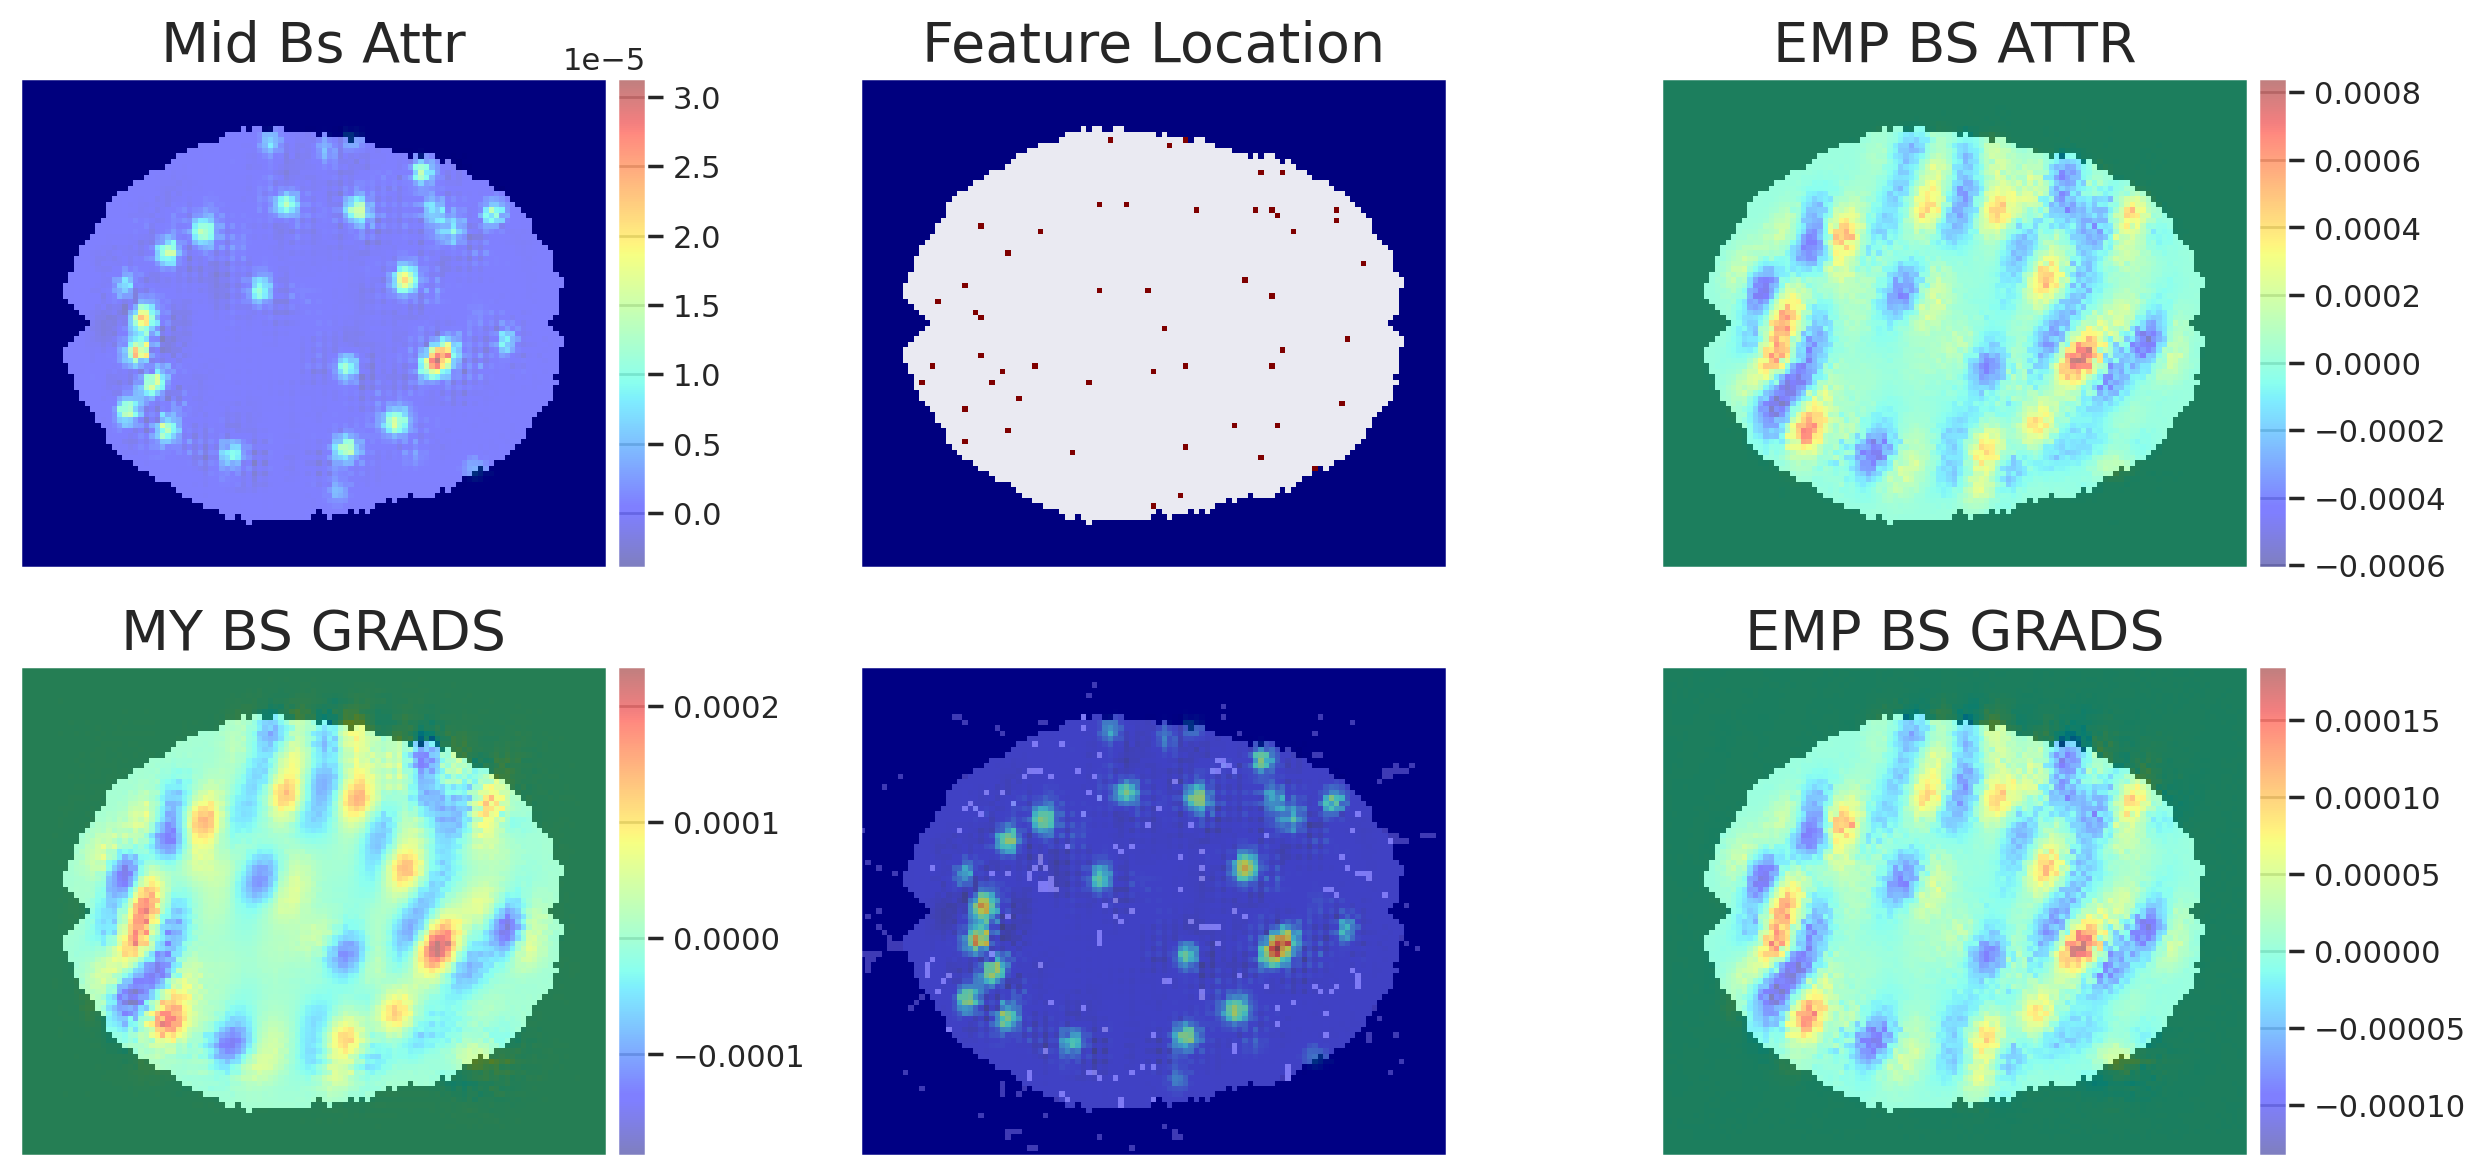

In [42]:

fig, ((ax0, ax2, ax1),(ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(15,7), dpi=200)

rc = {
      "figure.dpi": 500,
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 20}
plt.rcParams.update(rc)

ax1.imshow(brain_mask, cmap="gray")
ax0.imshow(brain_mask, cmap="gray")
ax2.imshow(temp, cmap="jet")

ax3.imshow(brain_mask, cmap="gray")
ax5.imshow(brain_mask, cmap="gray")
ax4.imshow(brain_mask, cmap="gray")
ax4.imshow(np.array(miss).reshape(AD_att.shape), alpha=.5)
ax4.imshow(AD_att, cmap="jet", alpha=0.5)


img0 = ax0.imshow(AD_att, cmap="jet", alpha=0.5)
img1 = ax1.imshow(AD_att_bs, cmap="jet", alpha=0.5)
divider1 = make_axes_locatable(ax1)
cax = divider1.append_axes('right', size='5%', pad=0.05)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img1, cax=cax, orientation='vertical')
fig.colorbar(img0, cax=cax0, orientation='vertical')


img3 = ax3.imshow(grads, cmap="jet", alpha=0.5)
img5 = ax5.imshow(grad_bs, cmap="jet", alpha=0.5)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)

divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img3, cax=cax3, orientation='vertical')
fig.colorbar(img5, cax=cax5, orientation='vertical')



ax0.set_title("Mid Bs Attr", fontsize=20); ax1.set_title("EMP BS ATTR", fontsize=20); ax2.set_title("Feature Location", fontsize=20);ax3.set_title("MY BS GRADS", fontsize=20);ax5.set_title("EMP BS GRADS", fontsize=20)
ax0.grid(False); ax1.grid(False),ax2.grid(False);ax3.grid(False); ax4.grid(False),ax5.grid(False)
for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [43]:
def k_largest_index_argpartition_v1(a, k):
    idx = np.argpartition(-a.ravel(),k)[:k]
    return np.column_stack(np.unravel_index(idx, a.shape))
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [44]:
top_idx = np.array(k_largest_index_argsort(abs(AD_att), 20))

In [45]:
inf = np.array(ind)
vettore_features_0 =np.array( [processed_data[i][top_idx[:,0], top_idx[:,1]] for i in classifed_idx[0]])
vettore_features_1 =np.array( [processed_data[i][top_idx[:,0], top_idx[:,1]] for i in classifed_idx[1]])

In [46]:
# flip indeces to plot
top_idx = top_idx[::-1]
top_idx = np.copy(top_idx)

# Class DISTR

In [47]:
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText


def add_pointer(ax, dir, start, c="g",lenght=.5):
    """
    Plots an arrow
    """
    arr = mpatches.FancyArrowPatch((start+(0.05 * dir), 120), (start+((0.05+lenght) * dir), 120),
                               arrowstyle='->', mutation_scale=50,color=c, linewidth=4)
    ax.add_patch(arr)


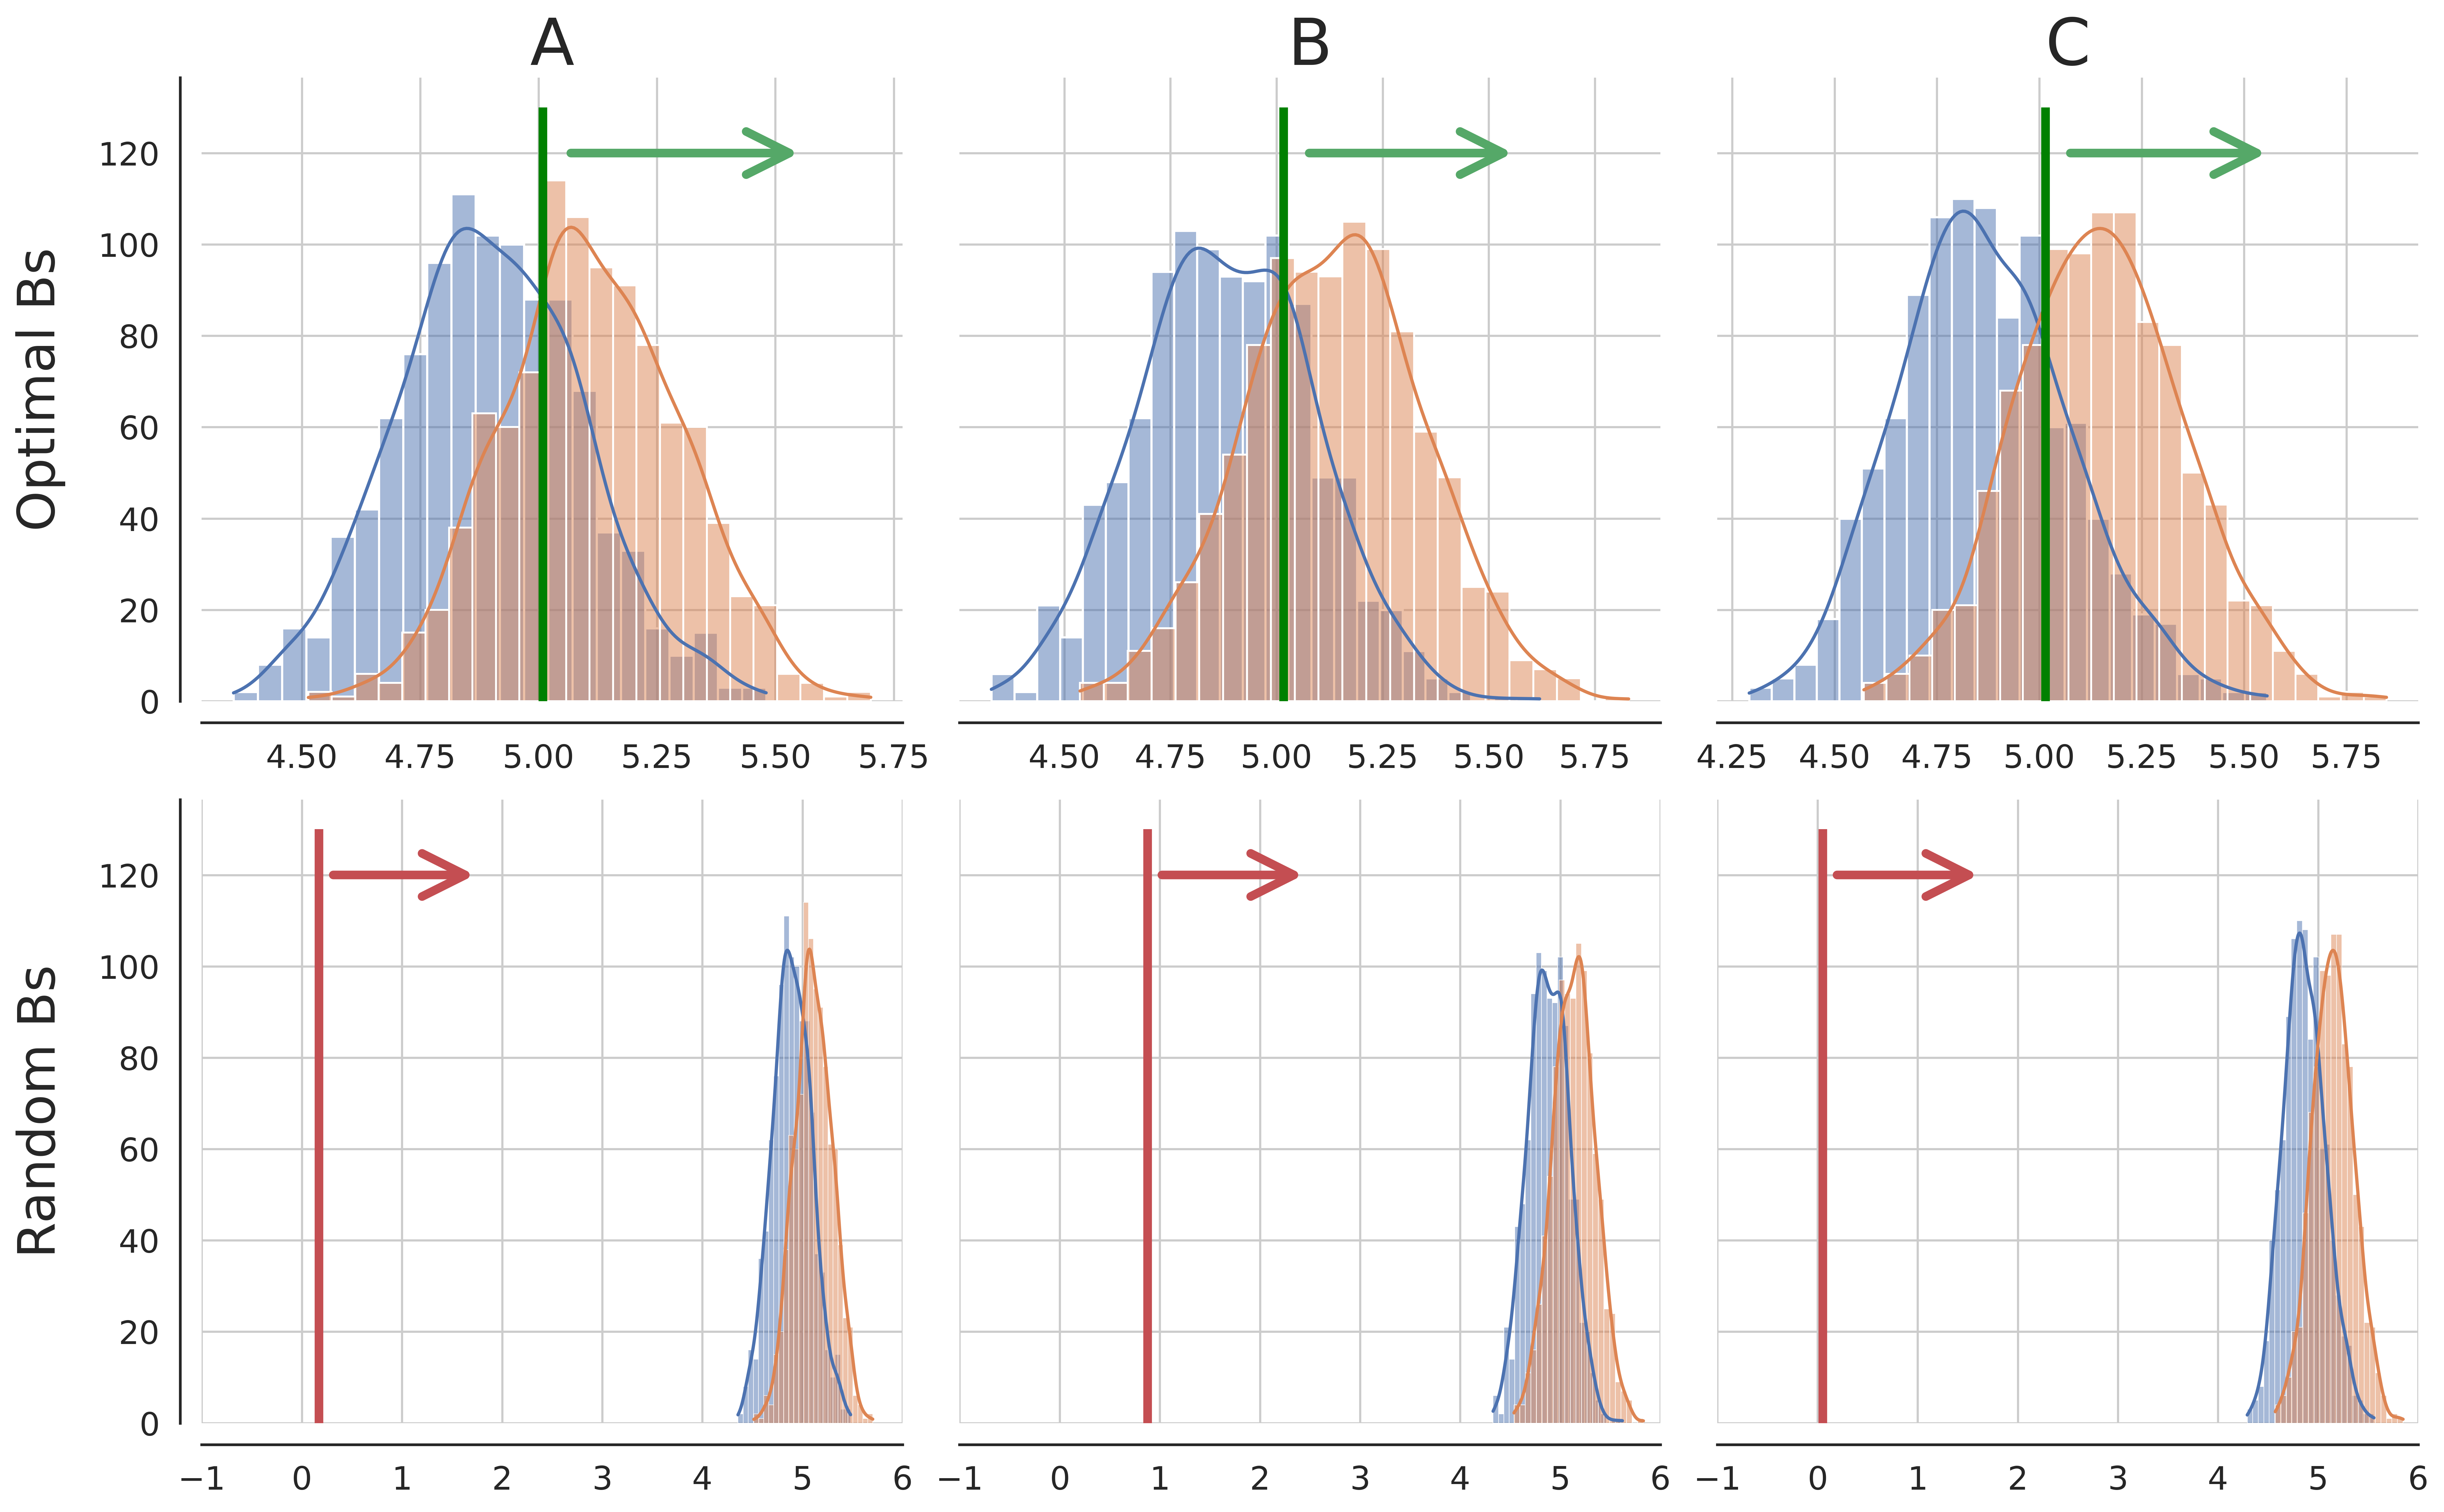

In [48]:
bs_plt = bs.cpu().numpy()
emp_plt = emp_bs.cpu().numpy()
sns.set_style("white")
rc = {'figure.figsize':(16,10),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
    #   'font.family':'Times New Roman',
    "axes.titlesize": 30,   # fontsize of the axes title
"axes.labelsize": "large",  # fontsize of the x any y labels

      'font.size' : 20}
plt.rcParams.update(rc)
# vettore_features_0.shape
# fig, (ax0,ax1) = plt.subplots(2,3, figsize=((10,6)), sharey=True)

vettore_features_0 =np.array( [processed_data[i][top_idx[:,0], top_idx[:,1]] for i in classifed_idx[0]])

vettore_features_1 =np.array( [processed_data[i][top_idx[:,0], top_idx[:,1]] for i in classifed_idx[1]])

top_grads_class0 = AD_att[top_idx[:,0], top_idx[:,1]]
# vettore_features_0.shape
fig, (ax0,ax1) = plt.subplots(2,3, figsize=((16,10)), sharey=True)
for i, (axx0, axx1) in enumerate(zip([*ax0], [*ax1])):
    # if i == 2:break
    add_pointer(axx0, np.sign(top_grads_class0[i]), bs_plt[0,0,top_idx[i,0], top_idx[i,1]])
    sns.histplot(vettore_features_0[:,i], kde=True, ax=axx0)
    sns.histplot(vettore_features_1[:,i], kde=True, ax=axx0)
    axx0.vlines(bs_plt[0,0,top_idx[i,0], top_idx[i,1]],0, 130, colors="green", linewidth=4)

    add_pointer(axx1, np.sign(top_grads_class0[i])*2, emp_plt[0,0,top_idx[i,0], top_idx[i,1]], c="r", lenght=.75)  
    sns.histplot(vettore_features_0[:,i], kde=True, ax=axx1)
    sns.histplot(vettore_features_1[:,i], kde=True, ax=axx1)
    axx1.vlines(emp_plt[0,0,top_idx[i,0], top_idx[i,1]],0, 130, colors="r", linewidth=4)
     
for ax, l in zip(ax0, ["A", "B", "C", "D", "E"]):
    ax.set_title(l) 
    # ax.set_xlim(3.5,5.5)

for ax in ax1:
    # ax.set_title("Random Bs")
    ax.set_xlim(-1,6)
for ax in [*ax1,*ax0]:
    ax.tick_params(labelsize=15)

ax0[0].set_ylabel("Optimal Bs", labelpad=15)
ax1[0].set_ylabel("Random Bs", labelpad=15)
fig.tight_layout()
sns.despine(left=True, offset=10)
sns.despine(ax=ax1[0], left=False, offset=10)
sns.despine(ax=ax0[0], left=False, offset=10)
plt.show()